## Naimportovaný marek.coderslab@gmail.com.ics z Google Calendar

In [2]:
import pandas as pd
from icalendar import Calendar

# Načti ICS soubor
with open("marek.coderslab@gmail.com.ics", "rb") as f:
    gcal = Calendar.from_ical(f.read())

events = []
for component in gcal.walk():
    if component.name == "VEVENT":
        events.append({
            "summary": str(component.get("summary")),
            "start": component.get("dtstart").dt,
            "end": component.get("dtend").dt,
            "description": str(component.get("description")),
        })

df = pd.DataFrame(events)
print(df.head())


       summary                     start                       end description
0  TOPFit: ZRT 2025-07-07 13:00:00+00:00 2025-07-07 14:00:00+00:00        None
1  TOPFit: ZRT 2025-06-30 12:45:00+00:00 2025-06-30 13:45:00+00:00        None
2   TOPFit: PB 2025-06-26 12:00:00+00:00 2025-06-26 13:00:00+00:00        None
3  TOPFIT: ZRT 2025-08-11 12:30:00+00:00 2025-08-11 13:30:00+00:00        None
4   TOPFit: PB 2025-07-03 13:30:00+00:00 2025-07-03 15:15:00+00:00         544


In [2]:
# !pip install icalendar


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


# Kód při stažení .zip s .ics z Export calendar "Marek.Coderslab"

In [14]:
import pandas as pd
from icalendar import Calendar
import zipfile
import re

zip_path = "marek.coderslab@gmail.com.ical.zip"

# otevřeme ZIP a najdeme ICS soubor
with zipfile.ZipFile(zip_path, "r") as z:
    # najdi soubor končící na .ics (pokud jich je víc, vezme první)
    ics_name = [f for f in z.namelist() if f.endswith(".ics")][0]
    with z.open(ics_name) as f:
        gcal = Calendar.from_ical(f.read())

events = []
for component in gcal.walk():
    if component.name == "VEVENT":
        summary = str(component.get("summary") or "")

        # odstraň prefix "TOPFIT:" bez ohledu na velikost
        clean_summary = re.sub(r"^\s*TOPFIT:\s*", "", summary, flags=re.IGNORECASE).strip()

        start = component.get("dtstart").dt
        end = component.get("dtend").dt

        events.append({
            "summary": clean_summary,
            "start": start,
            "end": end
        })

df_topfit = pd.DataFrame(events)

# jen datum
df_topfit["date"] = pd.to_datetime(df_topfit["start"]).dt.date

# délka v minutách
df_topfit["doba"] = (df_topfit["end"] - df_topfit["start"]).dt.total_seconds() / 60

# vyber sloupce a seřaď od nejnovějšího
df_topfit = df_topfit[["date", "summary", "doba"]].sort_values("date", ascending=False).reset_index(drop=True)

print(df_topfit.head(20))


          date            summary  doba
0   2025-08-28                ZRT  60.0
1   2025-08-21                 PB  60.0
2   2025-08-18                ZRT  60.0
3   2025-08-14                 PB  60.0
4   2025-08-11                ZRT  60.0
5   2025-08-07       Nohy, břicho  60.0
6   2025-08-04  PB - roztrž. ruky  60.0
7   2025-07-31                ZRT  60.0
8   2025-07-24                 PB  60.0
9   2025-07-22                ZRT  60.0
10  2025-07-17                 PB  60.0
11  2025-07-14                ZRT  60.0
12  2025-07-10                 PB  60.0
13  2025-07-07                ZRT  60.0
14  2025-07-03                 PB  60.0
15  2025-06-30                ZRT  60.0
16  2025-06-26                 PB  60.0


In [15]:
# !pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 3.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


# Kód využívající přímé připojení na Google calendar API

In [14]:
import os
import pandas as pd
import re
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from datetime import datetime

# Scope: jen čtení kalendáře
SCOPES = ["https://www.googleapis.com/auth/calendar.readonly"]

# Funkce pro získání service objektu
def get_service():
    creds = None
    if os.path.exists("token.json"):
        creds = Credentials.from_authorized_user_file("token.json", SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file("client_secret_1058953791301-pucaisjv7jacmllg5igtsftqlui6qmgd.apps.googleusercontent.com.json", SCOPES)
            creds = flow.run_local_server(port=0)
        with open("token.json", "w") as token:
            token.write(creds.to_json())
    service = build("calendar", "v3", credentials=creds)
    return service

# Funkce pro načtení událostí
def fetch_events(calendar_id, max_results=250):
    service = get_service()
    events_result = service.events().list(
        calendarId=calendar_id,
        timeMin="2000-01-01T00:00:00Z",  # začátek období
        maxResults=max_results,
        singleEvents=True,
        orderBy="startTime"
    ).execute()
    events = events_result.get("items", [])
    return events

def events_to_df(events):
    rows = []
    for e in events:
        summary = e.get("summary", "")
        clean_summary = re.sub(r"^\s*TOPFIT:\s*", "", summary, flags=re.IGNORECASE).strip()

        start_str = e["start"].get("dateTime", e["start"].get("date"))
        end_str = e["end"].get("dateTime", e["end"].get("date"))

        start_dt = pd.to_datetime(start_str)
        end_dt = pd.to_datetime(end_str)

        duration_min = (end_dt - start_dt).total_seconds() / 60

        # --- description ---
        description = e.get("description", "").strip()

        # číslo energie = první číslo
        match = re.search(r"\d+", description)
        energy = int(match.group(0)) if match else None

        # poznámka = text za pomlčkou
        note = None
        if "-" in description:
            note = description.split("-", 1)[1].strip()  # vezme část za první pomlčkou

        rows.append({
            "date": start_dt.date(),
            "summary": clean_summary,
            "doba": duration_min,
            "energy": energy,
            "note": note   # nový sloupec
        })

    df = pd.DataFrame(rows)

    # doplňkové sloupce
    df["month"] = pd.to_datetime(df["date"]).dt.month
    df["week"] = pd.to_datetime(df["date"]).dt.isocalendar().week

    df = df.sort_values("date", ascending=False).reset_index(drop=True)
    return df




# --- použití ---
calendar_id = "marek.coderslab@gmail.com"  # např. abc123@group.calendar.google.com
events = fetch_events(calendar_id)
df = events_to_df(events)

print(df)
# Uložení DataFrame do CSV
# df.to_csv("topfit_cviceni.csv", index=False, encoding="utf-8-sig")


          date       summary   doba  energy          note  month  week
0   2025-08-28           ZRT   60.0     NaN  tenis. loket      8    35
1   2025-08-21            PB   61.0   396.0  tenis. loket      8    34
2   2025-08-18           ZRT   74.0   399.0  tenis. loket      8    34
3   2025-08-14            PB   64.0   436.0          None      8    33
4   2025-08-11           ZRT   60.0     NaN          None      8    33
5   2025-08-07  Nohy, břicho   73.0   408.0          None      8    32
6   2025-08-04            PB   48.0   317.0  roztrž. ruky      8    32
7   2025-07-31           ZRT   76.0   392.0          None      7    31
8   2025-07-24            PB   96.0   519.0          None      7    30
9   2025-07-22           ZRT   74.0   450.0          None      7    30
10  2025-07-17            PB   64.0   422.0          None      7    29
11  2025-07-14           ZRT   56.0   491.0          None      7    29
12  2025-07-10            PB   99.0   490.0          None      7    28
13  20

In [12]:
for e in events:
    description = e.get("description", "")
    print(">>> description:", description)   # DEBUG, ať vidíš obsah


>>> description: 
>>> description: 
>>> description: 544
>>> description: 
>>> description: 490
>>> description: 491
>>> description: 422
>>> description: 450
>>> description: 519
>>> description: 392
>>> description: 317
- roztrž. ruky
>>> description: 408
>>> description: 
>>> description: 436
>>> description: 399
- tenis. loket
>>> description: 396
- tenis. loket
>>> description: - tenis. loket


## Sjednocení názvů workout

In [18]:
# Sjednocení názvů lekcí
def normalize_summary(text: str) -> str:
    text = text.strip().upper()
    if text.startswith("ZRT"):
        return "ZRT"
    elif text.startswith("PB"):
        return "PB"
    elif text.startswith("NOHY"):
        return "NOHY"
    else:
        return text  # fallback, pokud by bylo něco jiného

df["summary_norm"] = df["summary"].apply(normalize_summary)


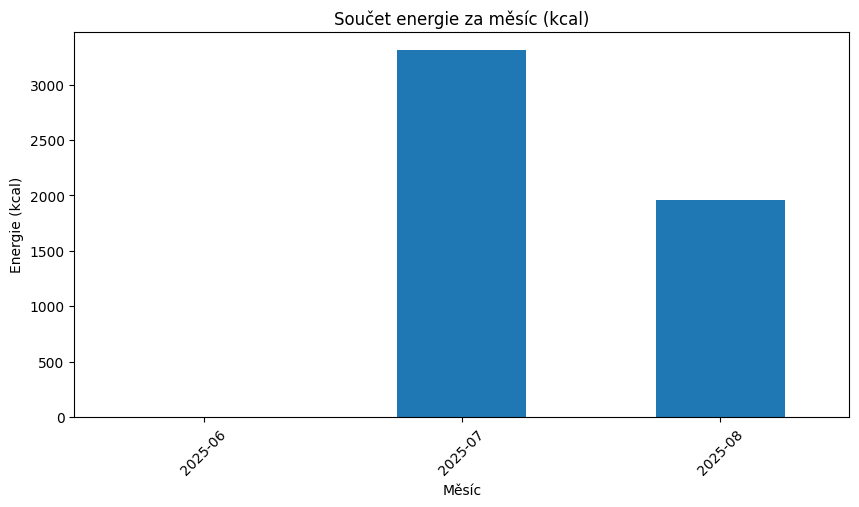

In [19]:
import matplotlib.pyplot as plt

# Měsíc jako perioda
df["month"] = pd.to_datetime(df["date"]).dt.to_period("M")

# součet energie za měsíc
energy_sum = df.groupby("month")["energy"].sum()

# graf
energy_sum.plot(kind="bar", figsize=(10,5))
plt.title("Součet energie za měsíc (kcal)")
plt.xlabel("Měsíc")
plt.ylabel("Energie (kcal)")
plt.xticks(rotation=45)
plt.show()


In [20]:
df

,date,summary,doba,energy,note,month,week,summary_norm
0,2025-08-28,ZRT,60.0,NaN,tenis. loket,2025-08,35,ZRT
1,2025-08-21,PB,61.0,396.0,tenis. loket,2025-08,34,PB
2,2025-08-18,ZRT,74.0,399.0,tenis. loket,2025-08,34,ZRT
3,2025-08-14,PB,64.0,436.0,None,2025-08,33,PB
4,2025-08-11,ZRT,60.0,NaN,None,2025-08,33,ZRT
5,2025-08-07,"Nohy, břicho",73.0,408.0,None,2025-08,32,NOHY
6,2025-08-04,PB,48.0,317.0,roztrž. ruky,2025-08,32,PB
7,2025-07-31,ZRT,76.0,392.0,None,2025-07,31,ZRT
8,2025-07-24,PB,96.0,519.0,None,2025-07,30,PB
9,2025-07-22,ZRT,74.0,450.0,None,2025-07,30,ZRT


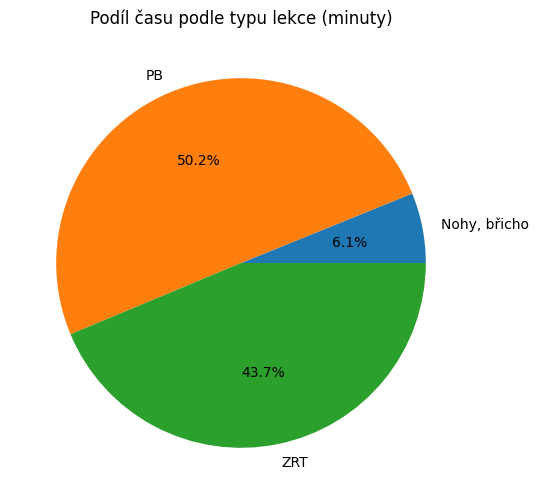

In [30]:
import matplotlib.pyplot as plt

# součet času (doba) podle typu lekce
time_per_lesson = df.groupby("summary")["doba"].sum()

# koláčový graf
time_per_lesson.plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(6,6)
)
plt.title("Podíl času podle typu lekce (minuty)")
plt.ylabel("")  # odstraní popisek y-osi
plt.show()



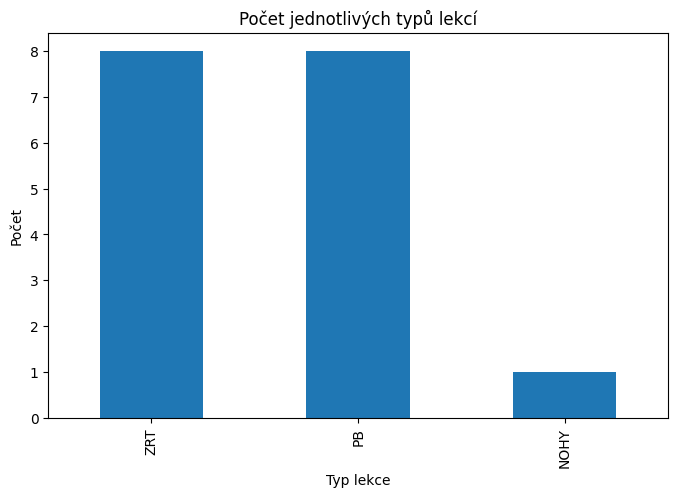

In [22]:
df["summary_norm"].value_counts().plot(kind="bar", figsize=(8,5))
plt.title("Počet jednotlivých typů lekcí")
plt.xlabel("Typ lekce")
plt.ylabel("Počet")
plt.show()


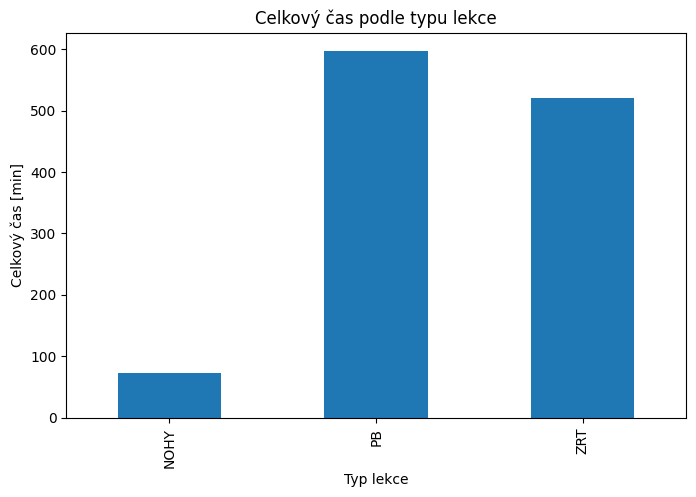

In [28]:
df.groupby("summary_norm")["doba"].sum().plot(kind="bar", figsize=(8,5))
plt.title("Celkový čas podle typu lekce")
plt.ylabel("Celkový čas [min]")
plt.xlabel("Typ lekce")
plt.show()


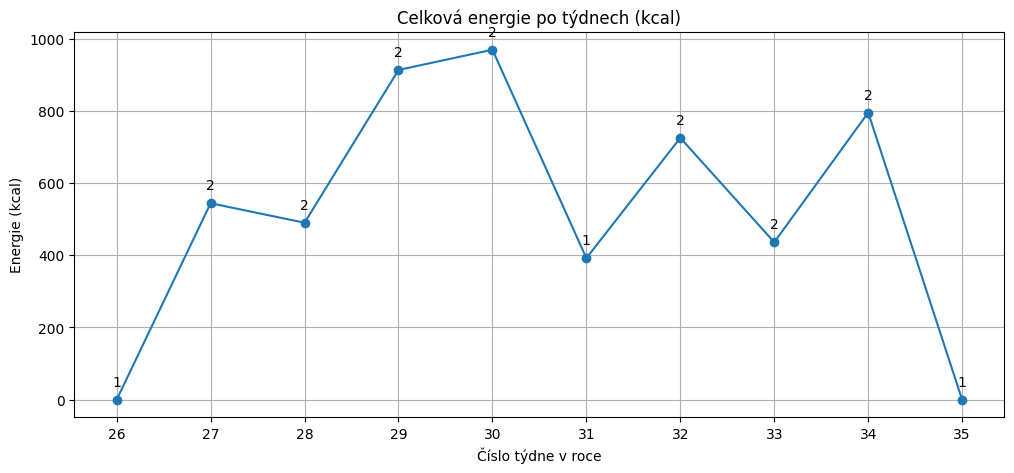

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# jistota: ISO týden jako int
df["week"] = pd.to_datetime(df["date"]).dt.isocalendar().week.astype(int)

# kompletní rozsah týdnů (v rámci dat v df)
all_weeks = pd.RangeIndex(df["week"].min(), df["week"].max() + 1)

# součet energie po týdnech (0 pro chybějící týdny)
weekly_energy = (
    df.groupby("week", observed=True)["energy"]
      .sum(min_count=1)              # když v týdnu není žádná energie, zůstane NaN
      .reindex(all_weeks, fill_value=0)
      .fillna(0)
)

# počet lekcí po týdnech (pro popisky)
weekly_counts = (
    df.groupby("week", observed=True)
      .size()
      .reindex(all_weeks, fill_value=0)
)

# graf
ax = weekly_energy.plot(kind="line", marker="o", figsize=(12, 5))
plt.title("Celková energie po týdnech (kcal)")
plt.xlabel("Číslo týdne v roce")
plt.ylabel("Energie (kcal)")
plt.xticks(list(all_weeks))
plt.grid(True)

# popisky: počet lekcí nad body
offset = max(1, weekly_energy.max() * 0.03)  # drobný odsaz
for week, value in weekly_energy.items():
    ax.text(week, value + offset, str(int(weekly_counts.loc[week])), ha="center", va="bottom")

plt.show()



/var/folders/px/7v29qw4j1fq7r7dx3wzzggyr0000gn/T/ipykernel_890/870990419.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")   # nebo "viridis", "plasma" atd.


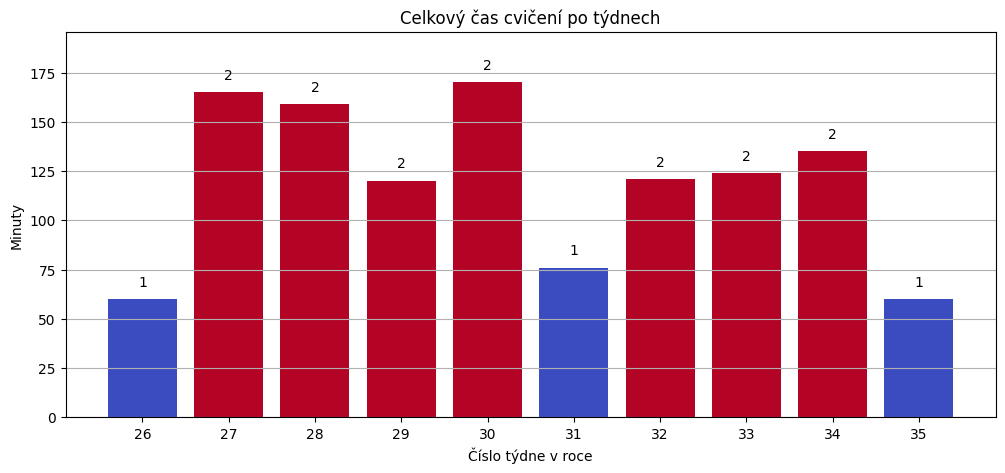

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# --- jistota: vytvoř sloupec week jako int ---
df["week"] = pd.to_datetime(df["date"]).dt.isocalendar().week.astype(int)

# kompletní rozsah týdnů (int list)
start_week = int(df["week"].min())
end_week = int(df["week"].max())
all_weeks = list(range(start_week, end_week + 1))

# součet minut (doba) po týdnech, přeuspořádaný podle all_weeks
weekly_minutes = (
    df.groupby("week", observed=True)["doba"]
      .sum()
      .reindex(all_weeks, fill_value=0)
      .astype(float)
)

# počet lekcí po týdnech (pro barvy / popisky)
weekly_counts = (
    df.groupby("week", observed=True)
      .size()
      .reindex(all_weeks, fill_value=0)
      .astype(int)
)

# --- barevná škála podle počtu lekcí ---
vmin = weekly_counts.min()
vmax = weekly_counts.max()
# zabrání dělení nulou, když jsou všechny hodnoty stejné
if vmin == vmax:
    norm = plt.Normalize(vmin - 1, vmax + 1)
else:
    norm = plt.Normalize(vmin, vmax)
cmap = cm.get_cmap("coolwarm")   # nebo "viridis", "plasma" atd.
colors = cmap(norm(weekly_counts.values))

# --- vykreslení ---
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(all_weeks))  # pozice na ose x

bars = ax.bar(x, weekly_minutes.values, color=colors)
ax.set_ylim(0, max(130, weekly_minutes.max() * 1.15))  # minimální max 130, nebo dynamické
ax.set_title("Celkový čas cvičení po týdnech")
ax.set_xlabel("Číslo týdne v roce")
ax.set_ylabel("Minuty")
ax.set_xticks(x)
ax.set_xticklabels(all_weeks, rotation=0)
ax.grid(axis="y")

# přidání počtu lekcí nad sloupce
offset = max(1, weekly_minutes.max() * 0.03)
for i, (val, cnt) in enumerate(zip(weekly_minutes.values, weekly_counts.values)):
    ax.text(i, val + offset, str(int(cnt)), ha='center', va='bottom')

plt.show()



Sekvenční (pro hodnoty od nízké po vysokou)

    viridis – tmavě modrá → žlutá, velmi dobře čitelná

    plasma – fialová → žlutá, kontrastní a živá

    inferno – černá → žlutá, hodně kontrastu

    magma – tmavá → světle fialová, jemnější než inferno

    cividis – modro-žlutá, vhodné pro barevně slabozraké

2️⃣ Divergentní (pro hodnoty kolem střední hodnoty)

    coolwarm – modrá ↔ červená

    bwr – modrá ↔ bílá ↔ červená

    seismic – tmavě modrá ↔ bílá ↔ červená

3️⃣ Kategorické / diskrétní

    tab10, tab20, Set1, Set2, Accent – pro oddělení skupin/barvy jednotlivých kategorií